In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import os
import ast

In [2]:
def get_resdf(file_t, start, end, step=50, group_sims=True):
    fd = "../results/data"
    res_str = "{'board_type':"
    res_cols = ["agent2_MCTS_sims", "agent1_p1_wins", "agent1_p2_wins", "agent2_p1_wins", "agent2_p2_wins"]
    df = pd.DataFrame(columns=res_cols)

    for sims in range(start, end+1, step):
        fn = file_t.format(sims)
        fp = os.path.join(fd, fn)
        if os.path.isfile(fp):
            with open(fp) as file:
                results = [ast.literal_eval(line[line.find(res_str):]) for line in file if res_str in line]
            dfs = pd.DataFrame(results)[res_cols]
            df = df.append(dfs)

    if group_sims:
        df = df.groupby(['agent2_MCTS_sims']).sum()
        
    return df

In [3]:
def plot_results(df, title, agent_name=['NN', 'MCTS']):
    prcn = [agent_name[0]+" wins as Player 1", agent_name[0]+" wins as Player 2", agent_name[1]+" wins as Player 1", agent_name[1]+" wins as Player 2"]
    trcn = [agent_name[0]+" total wins", agent_name[1]+" total wins"]
    df = df.rename_axis("MCTS Simulations per Move")
    df.columns = prcn
    df[trcn[0]] = df[prcn[0]] + df[prcn[1]]
    df[trcn[1]] = df[prcn[2]] + df[prcn[3]]

    plt.rcParams['figure.figsize'] = [15, 5]
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.suptitle(title)

    df[trcn].plot(ax=ax1, marker="+")
    ax1.legend(loc='best')
    df[prcn].plot(ax=ax2, marker="+")
    ax2.legend(loc='best')


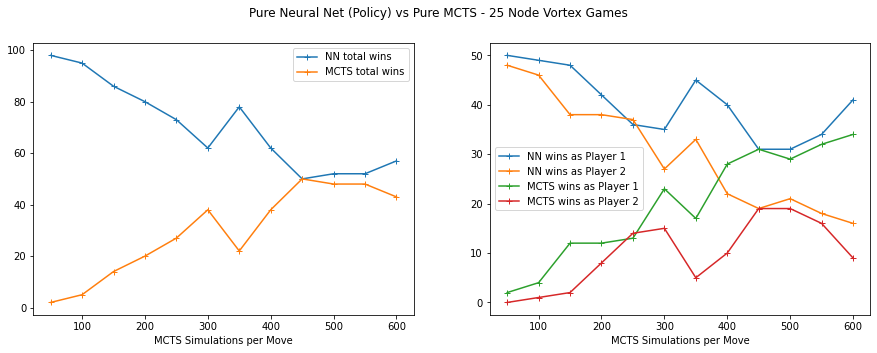

In [4]:
df = get_resdf("results_5x5_{}s.txt", 50, 600)
plot_results(df, "Pure Neural Net (Policy) vs Pure MCTS - 25 Node Vortex Games")

#df.columns = ["NNP1", "NNP2", "MCTSP1", "MCTSP2"]
#print(df)

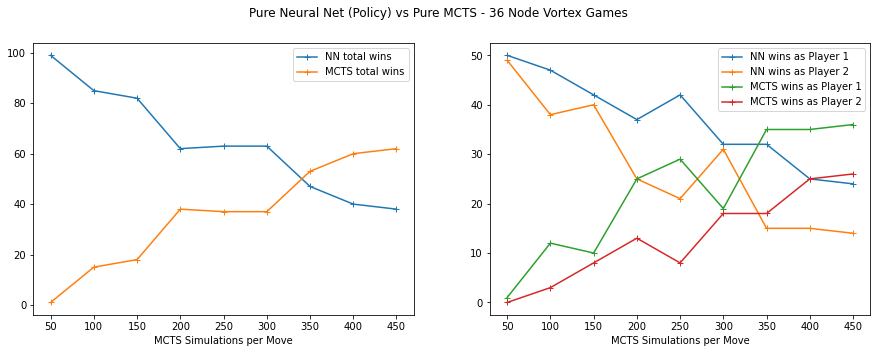

In [5]:
df = get_resdf("results_6x6_{}s.txt", 50, 450)
plot_results(df, "Pure Neural Net (Policy) vs Pure MCTS - 36 Node Vortex Games")


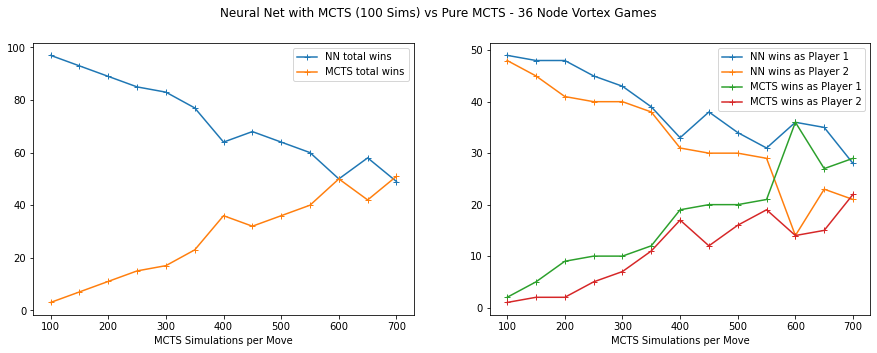

In [6]:
df = get_resdf("results_MCTSnet100_6x6_{}s.txt", 100, 700)
plot_results(df, "Neural Net with MCTS (100 Sims) vs Pure MCTS - 36 Node Vortex Games")

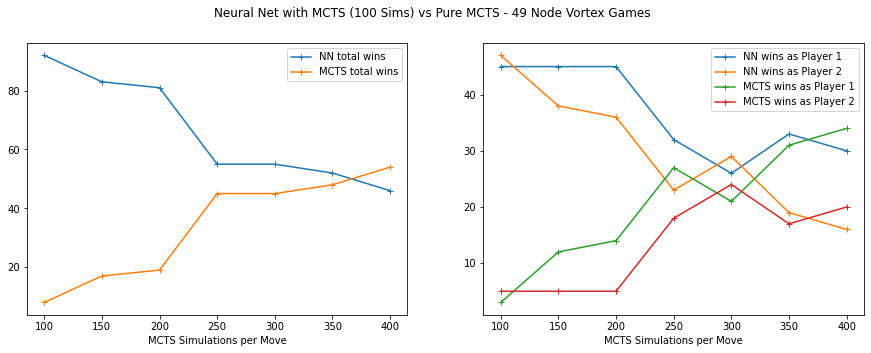

In [7]:
df = get_resdf("results_MCTSnet100_7x7_{}s.txt", 100, 400)
plot_results(df, "Neural Net with MCTS (100 Sims) vs Pure MCTS - 49 Node Vortex Games")

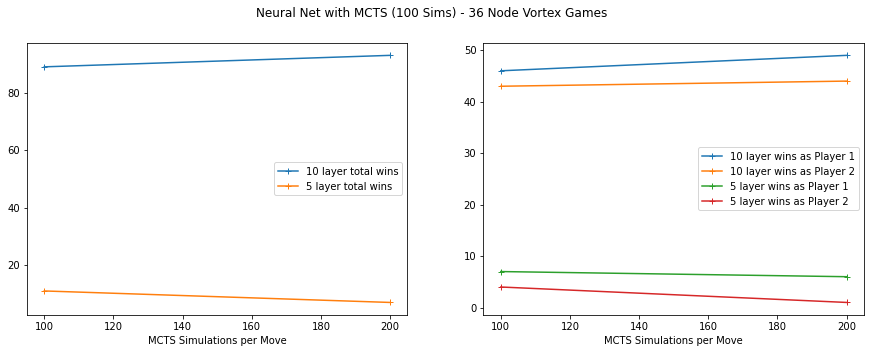

In [8]:

df = get_resdf("netvnet_6x6_{}s.txt", 100, 200, step=100)
plot_results(df, "Neural Net with MCTS (100 Sims) - 36 Node Vortex Games", agent_name=['10 layer', '5 layer'])

In [22]:
df

,agent1_p1_wins,agent1_p2_wins,agent2_p1_wins,agent2_p2_wins
agent2_MCTS_sims,,,,
100,46,43,7,4
200,49,44,6,1


In [9]:
import numpy as np
import torch

In [10]:
A = torch.zeros(7,7)
A[0,1] = 1
A[0,2] = 1
A[1,3] = 1
A[2,3] = 1
A[3,4] = 1
A[3,5] = 1
A[4,6] = 1
A[5,6] = 1
A

tensor([[0., 1., 1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 1., 1., 0.],
        [0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0.]])

In [11]:
A2 = (A.matmul(A)-1).relu() + A
A2

tensor([[0., 1., 1., 1., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 1., 1., 1.],
        [0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0.]])

In [12]:
A2.matmul(A2)

tensor([[0., 0., 0., 2., 1., 1., 1.],
        [0., 0., 0., 0., 1., 1., 1.],
        [0., 0., 0., 0., 1., 1., 1.],
        [0., 0., 0., 0., 0., 0., 2.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.]])

In [13]:
edge_index = torch.tensor([[0,0,1,2,3,3,4,5],[1,2,3,3,4,5,6,6]])
edge_index = torch.cat([edge_index, edge_index[[1,0]]], dim=1)
A = torch.sparse_coo_tensor(indices=edge_index, values=torch.ones_like(edge_index[0]), size=(7,7))
Ad = A.to_dense()
(Ad.matmul(Ad) - 1).relu().nonzero()

tensor([[0, 0],
        [0, 3],
        [1, 1],
        [1, 2],
        [2, 1],
        [2, 2],
        [3, 0],
        [3, 3],
        [3, 6],
        [4, 4],
        [4, 5],
        [5, 4],
        [5, 5],
        [6, 3],
        [6, 6]])

In [14]:
Ad

tensor([[0, 1, 1, 0, 0, 0, 0],
        [1, 0, 0, 1, 0, 0, 0],
        [1, 0, 0, 1, 0, 0, 0],
        [0, 1, 1, 0, 1, 1, 0],
        [0, 0, 0, 1, 0, 0, 1],
        [0, 0, 0, 1, 0, 0, 1],
        [0, 0, 0, 0, 1, 1, 0]])

In [15]:
# connectivity distance 0
(Ad.matmul(Ad) > 1).long().fill_diagonal_(0) + Ad

tensor([[0, 1, 1, 1, 0, 0, 0],
        [1, 0, 1, 1, 0, 0, 0],
        [1, 1, 0, 1, 0, 0, 0],
        [1, 1, 1, 0, 1, 1, 1],
        [0, 0, 0, 1, 0, 1, 1],
        [0, 0, 0, 1, 1, 0, 1],
        [0, 0, 0, 1, 1, 1, 0]])

In [16]:
# connectivity distance 0
# tree depth 2
A0c = torch.einsum('ij,jk->ikj',Ad,Ad)
A0 = (A0c.sum(dim=2) > 1).long().fill_diagonal_(0) + Ad
A0, A0c

(tensor([[0, 1, 1, 1, 0, 0, 0],
         [1, 0, 1, 1, 0, 0, 0],
         [1, 1, 0, 1, 0, 0, 0],
         [1, 1, 1, 0, 1, 1, 1],
         [0, 0, 0, 1, 0, 1, 1],
         [0, 0, 0, 1, 1, 0, 1],
         [0, 0, 0, 1, 1, 1, 0]]),
 tensor([[[0, 1, 1, 0, 0, 0, 0],
          [0, 0, 0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0, 0, 0],
          [0, 1, 1, 0, 0, 0, 0],
          [0, 0, 0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0, 0, 0]],
 
         [[0, 0, 0, 0, 0, 0, 0],
          [1, 0, 0, 1, 0, 0, 0],
          [1, 0, 0, 1, 0, 0, 0],
          [0, 0, 0, 0, 0, 0, 0],
          [0, 0, 0, 1, 0, 0, 0],
          [0, 0, 0, 1, 0, 0, 0],
          [0, 0, 0, 0, 0, 0, 0]],
 
         [[0, 0, 0, 0, 0, 0, 0],
          [1, 0, 0, 1, 0, 0, 0],
          [1, 0, 0, 1, 0, 0, 0],
          [0, 0, 0, 0, 0, 0, 0],
          [0, 0, 0, 1, 0, 0, 0],
          [0, 0, 0, 1, 0, 0, 0],
          [0, 0, 0, 0, 0, 0, 0]],
 
         [[0, 1, 1, 0, 0, 0, 0],
          [0, 0, 0, 0, 0, 0, 0],
      

In [17]:
# connectivity distance 1?
(A0.matmul(A0) == 1).long()
#A0.matmul(A0)

tensor([[0, 0, 0, 0, 1, 1, 1],
        [0, 0, 0, 0, 1, 1, 1],
        [0, 0, 0, 0, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 0, 0, 0, 0],
        [1, 1, 1, 0, 0, 0, 0],
        [1, 1, 1, 0, 0, 0, 0]])

In [18]:
v1 = np.array([0,1,1,0])
v2 = np.array([0,1,1,1])
v1 * v2

array([0, 1, 1, 0])

In [19]:
Ad = Ad.numpy()
Ad

array([[0, 1, 1, 0, 0, 0, 0],
       [1, 0, 0, 1, 0, 0, 0],
       [1, 0, 0, 1, 0, 0, 0],
       [0, 1, 1, 0, 1, 1, 0],
       [0, 0, 0, 1, 0, 0, 1],
       [0, 0, 0, 1, 0, 0, 1],
       [0, 0, 0, 0, 1, 1, 0]], dtype=int64)

In [20]:
np.dot(Ad, Ad)

array([[2, 0, 0, 2, 0, 0, 0],
       [0, 2, 2, 0, 1, 1, 0],
       [0, 2, 2, 0, 1, 1, 0],
       [2, 0, 0, 4, 0, 0, 2],
       [0, 1, 1, 0, 2, 2, 0],
       [0, 1, 1, 0, 2, 2, 0],
       [0, 0, 0, 2, 0, 0, 2]], dtype=int64)

In [21]:
np.einsum('ij,jk->ikj',Ad,Ad)

array([[[0, 1, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0],
        [0, 1, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0]],

       [[0, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 1, 0, 0, 0],
        [1, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0]],

       [[0, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 1, 0, 0, 0],
        [1, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0]],

       [[0, 1, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0],
        [0, 1, 1, 0, 1, 1, 0],
        [0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 1, 0]],

       [[0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0],
